# Diminishing fitness benefits with increasing cell type diversity can explain cell type allometry

In [410]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
from scipy.optimize import curve_fit 
import pymc as pm
import arviz as az

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

### Definitions

In [418]:
def fitfun_power(N,off,slope_small,slope_large,Nbp):

    return [off + slope_small*n if n < Nbp 
            else off + slope_small*Nbp + slope_large*(n-Nbp)
            for n in N]

def fitfun_new(N,A,B):
    return np.log10(A + B*N)

def BIC(rss,n_dat,n_params):
    return n_dat*np.log(rss/n_dat) + n_params*np.log(n_dat)

def plot_model(dat,trace,ax,hdp_prob=95):
    
    mu_mean = trace.posterior['mu'].mean(axis=1).mean(axis=0)

    # plot mean
    ax.plot(x_dat,mu_mean,'-', color=mypalette[0],lw=3,label = 'mean regression line')

    # plot hdi for mean (=regression curve)  
    sig = az.plot_hdi(x_dat, trace.posterior['mu'], hdi_prob=hdp_prob/100, 
                      fill_kwargs = {'label' : str(hdp_prob)+"% HDI of regression line"},
                      color=mypalette[0],ax=ax)

    # plot hdi for ppd
    sigpp = az.plot_hdi(x_dat, trace.posterior_predictive['y'], 
                        fill_kwargs = {'label' : str(hdp_prob)+"% HDI of PPD"},
                        hdi_prob=hdp_prob/100, color=mypalette[1],ax=ax)

    # plot data
    ax.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
             markeredgecolor='black',markerfacecolor='white',markeredgewidth=2,
             label = 'data from Fisher et al.')

    # az.plot_lm(idata=trace,x=x_dat,y='y',y_model='mu',kind_pp="hdi", kind_model="hdi")

    ax.set_ylim([-0.8,2.5])
    ax.set_xlabel('$log_{10}$(Number of cells)')
    ax.set_ylabel('$log_{10}$(Number of cell types)')


def get_post_mean(trace,param):
    return np.round(trace.posterior[param].mean().values,2)

def get_hdi(trace,param):
    return np.round(az.hdi(trace,hdi_prob=0.95),2)[param].values

mypalette = ['xkcd:royal blue','xkcd:tangerine']

### Load data

In [414]:
data = pd.read_excel('curbio10341mmc2.xlsx')
dat = data.loc[:,['Total number of cells','Number of cell types']].dropna()
dat.columns = ['N','K']

# breakpoint reported by Fisher et al.
Nbp = np.log10(6.3e4)
# split of data accoring to 
# dat_small = dat.loc[dat['N'] <= 6.3e4,:]
# dat_big = dat.loc[dat['N'] > 6.3e4,:]

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Rough analysis with ordinary least squares fit 

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


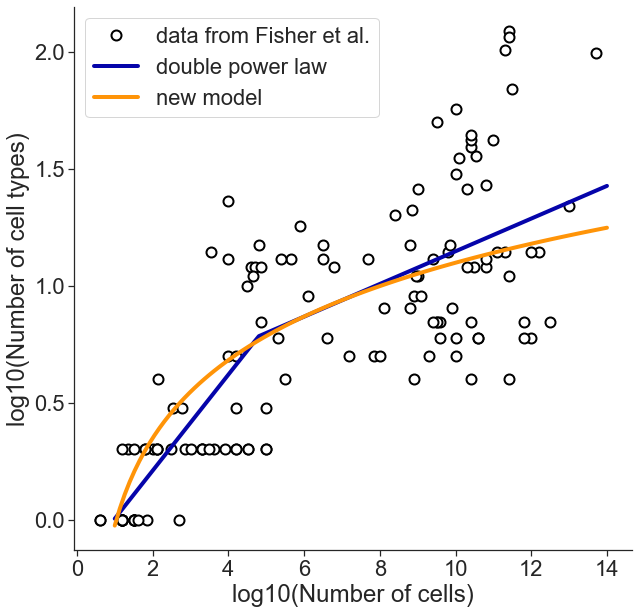

In [438]:
sns.set(font_scale=2,style="ticks")
fig,ax = plt.subplots(figsize=[10,10])


# plot data
plt.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
         markeredgecolor='black',markerfacecolor='white',markeredgewidth=2)


# fit double power law 
fitfun = partial(fitfun_power,Nbp=Nbp)
fitparam_power,pcov = curve_fit(fitfun,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for double power law
RSS_power = sum((np.log10(dat['K']) - fitfun_power(np.log10(dat['N']),*fitparam_power,Nbp=Nbp))**2)


# plot double power law
x = np.linspace(1,14,100)
y = fitfun_power(x,*fitparam_power,Nbp=Nbp)
l1 = ax.plot(x,y,'-',color=mypalette[0],linewidth=4);


# fit new model
fitparam_new,pcov = curve_fit(fitfun_new,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for new model
RSS_new = sum((np.log10(dat['K']) - log10fitfun(np.log10(dat['N']),*fitparam_new))**2)

# # plot new model
x = np.linspace(1,14,100)
y = fitfun_new(x,*fitparam_new)
l2 = ax.plot(x,y,'-',color=mypalette[1],linewidth=4);

ax.set_xlabel('log10(Number of cells)')
ax.set_ylabel('log10(Number of cell types)')

ax.legend(['data from Fisher et al.','double power law','new model'])

sns.despine()


Residual sum of squares [RSS new model, RSS double power law]

In [457]:
np.round([RSS_new,RSS_power],2)

array([14.28, 13.22])

Bayesian information criterion [BIC new model, BIC double power law] 

In [458]:
np.round([BIC(RSS_new,dat.shape[0],2),BIC(RSS_power,dat.shape[0],3)],2)

array([-286.99, -292.41])

Double power law parameters [offset, slope_small, slope_large]

In [459]:
fitparam_power

array([-0.1998514 ,  0.20506008,  0.06980782])

New model parameters : [A,B]

In [460]:
fitparam_new

array([-0.34285462,  1.28871636])

## Bayesian regression

In [122]:
x_dat = np.log10(dat.sort_values(by='N')['N'])
y_dat = np.log10(dat.sort_values(by='N')['K'])

## Model definition and sampling

In [454]:
models = ['double power law, constant sd','double power law, variable sd',
         'new model, constant sd', 'new model, variable sd']

trace = dict()

### Double power law, constant sd 

In [374]:
with pm.Model() as plaw_simple_model:

    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    
    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)

    slope_1 = pm.Normal('slope_1', mu=0, sigma=20)
    slope_2 = pm.Normal('slope_2', mu=0, sigma=20)
    
    intercept_1 = pm.Uniform('intercept_1', lower=-0.5, upper=0.5, initval = 0.1)

    part_1 = intercept_1 + slope_1 * x_dat
    part_2 = intercept_1 + slope_1 * breakpoint - slope_2 * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    trace['double power law, constant sd'] = pm.sample(10000,target_accept=0.8,tune=2000, progressbar=True)
    
    pm.sample_posterior_predictive(trace_plaw_simple, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [breakpoint, sigma, slope_1, slope_2, intercept_1]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 86 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


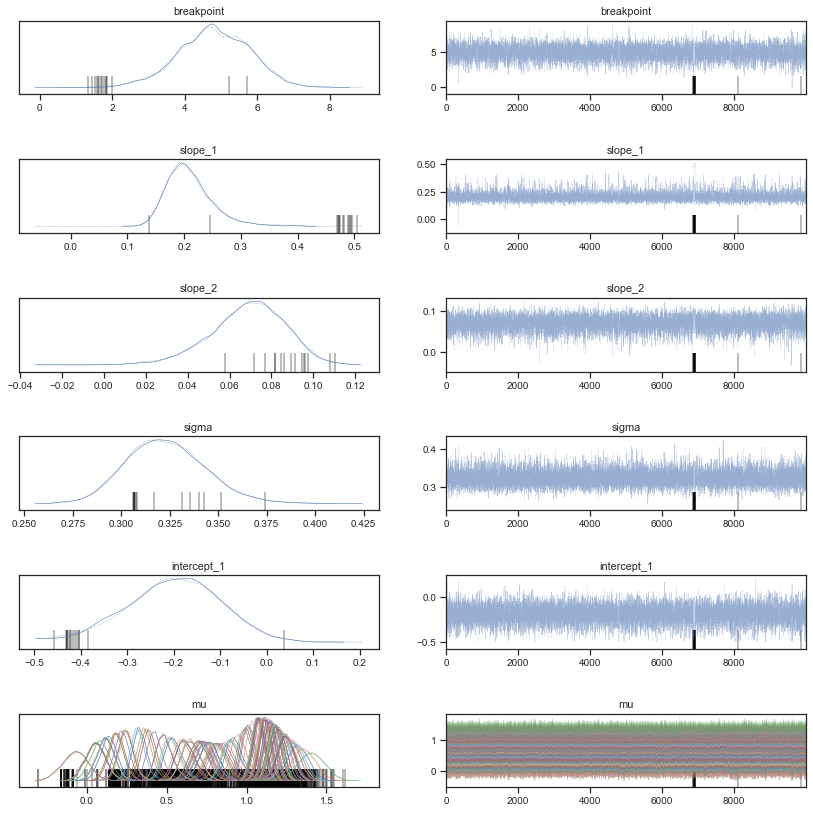

In [375]:
az.plot_trace(trace['double power law, constant sd'])
plt.tight_layout()

### Double power law; sd depends on cell number

In [376]:
with pm.Model() as plaw_complete_model:

    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    
    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)      
    
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 
    
    # sigma = pm.Deterministic('sigma',pm.math.exp(sigma_intercept + sigma_slope * x_dat)) 

    slope_1 = pm.Normal('slope_1', mu=0, sigma=20)
    slope_2 = pm.Normal('slope_2', mu=0, sigma=20)
    
    intercept_1 = pm.Uniform('intercept_1', lower=-0.5, upper=0.5, initval = 0.1)

    part_1 = intercept_1 + slope_1 * x_dat
    part_2 = intercept_1 + slope_1 * breakpoint - slope_2 * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    trace_plaw_complete = pm.sample(10000,target_accept=0.8,tune=2000, progressbar=True)
    
    pm.sample_posterior_predictive(trace_plaw_complete, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [breakpoint, sigma_intercept, sigma_slope, slope_1, slope_2, intercept_1]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 71 seconds.


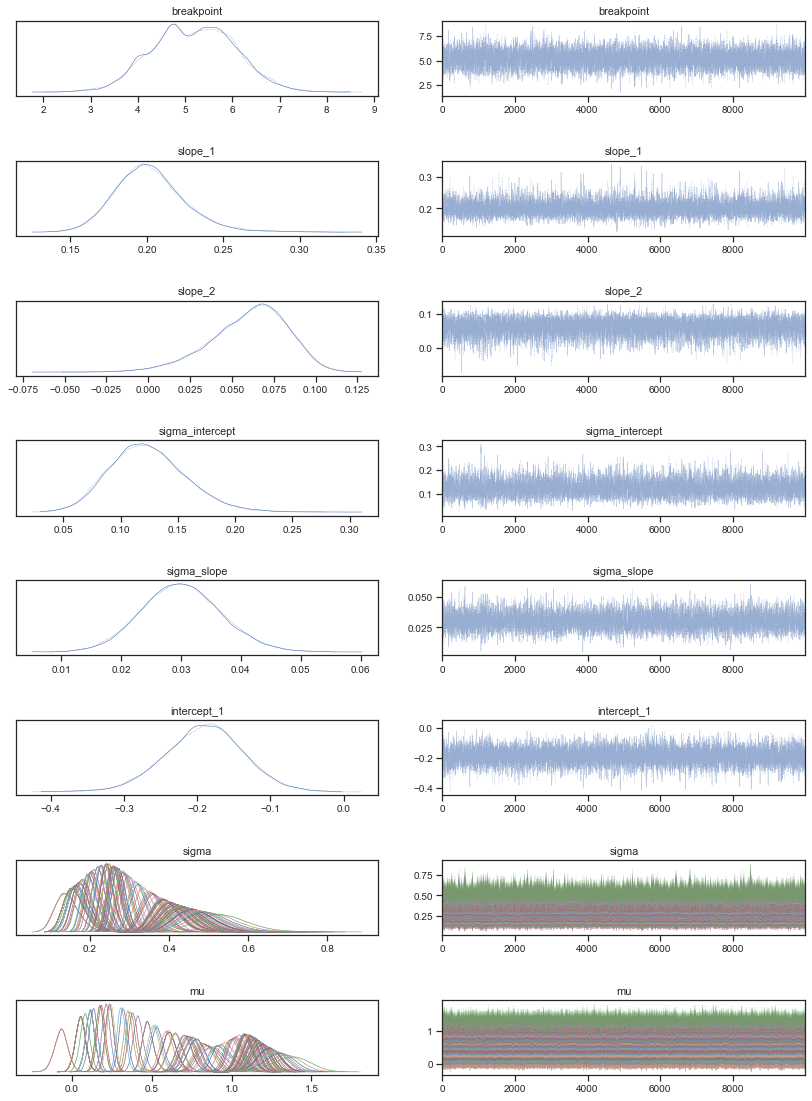

In [377]:
az.plot_trace(trace_plaw_complete)
plt.tight_layout()

### New model; sd does NOT depend on cell number

In [378]:
with pm.Model() as new_simple_model:
    
    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)

    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    trace_new_simple = pm.sample(10000,target_accept=0.8,tune=2000, progressbar=True)
    
    pm.sample_posterior_predictive(trace_new_simple, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, A, B]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.


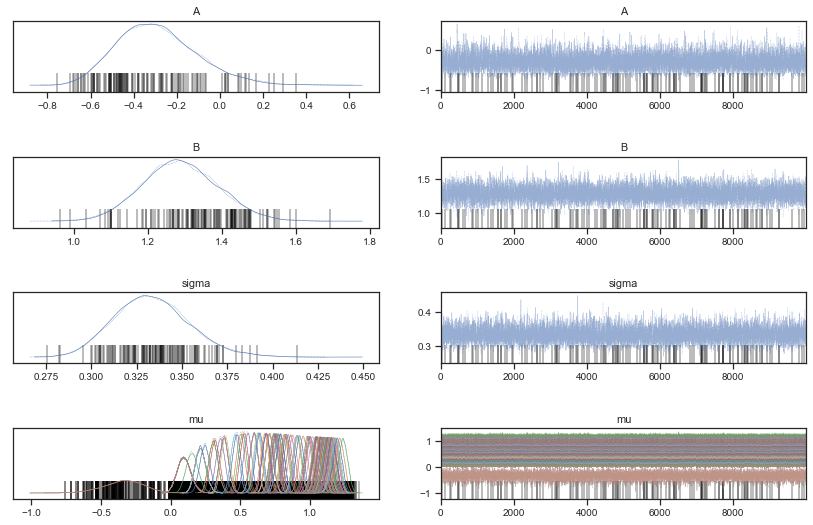

In [379]:
az.plot_trace(trace_new_simple)
plt.tight_layout()

### New model complete; sd depends on cell number

In [380]:
with pm.Model() as new_complete_model:
    
    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)    
    
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 

    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    trace_new_complete = pm.sample(10000,target_accept=0.8,tune=2000, progressbar=True)
    
    pm.sample_posterior_predictive(trace_new_complete, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_intercept, sigma_slope, A, B]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 33 seconds.


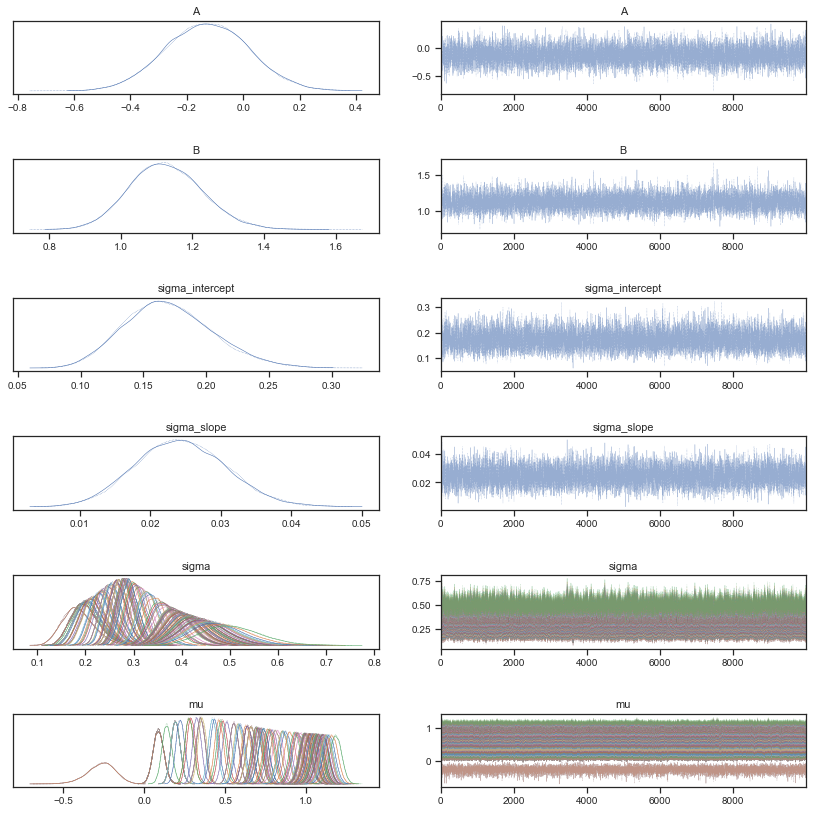

In [381]:
az.plot_trace(trace_new_complete)
plt.tight_layout()

## Model comparison

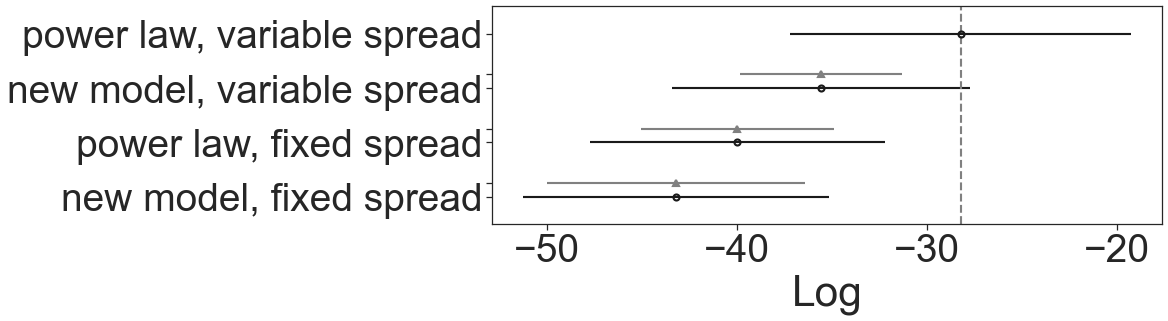

In [382]:
model_compare = az.compare(
    {
        "power law, fixed spread": trace_plaw_simple,
        "power law, variable spread": trace_plaw_complete,
        "new model, fixed spread": trace_new_simple,
        "new model, variable spread": trace_new_complete,

    },
    ic='loo'
)

az.plot_compare(model_compare,insample_dev=False, figsize=(12, 4))

plt.show()

In [383]:
model_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
"power law, variable spread",0,-28.232994,5.530155,0.000000,8.659398e-01,8.971387,0.000000,False,log
"new model, variable spread",1,-35.589735,3.845445,7.356742,7.776960e-14,7.831272,4.279617,False,log
"power law, fixed spread",2,-39.984600,4.341807,11.751606,9.039723e-14,7.755705,5.068459,False,log
"new model, fixed spread",3,-43.229865,2.585107,14.996871,1.340602e-01,8.050301,6.792187,False,log


### Plot results (Figure 1)

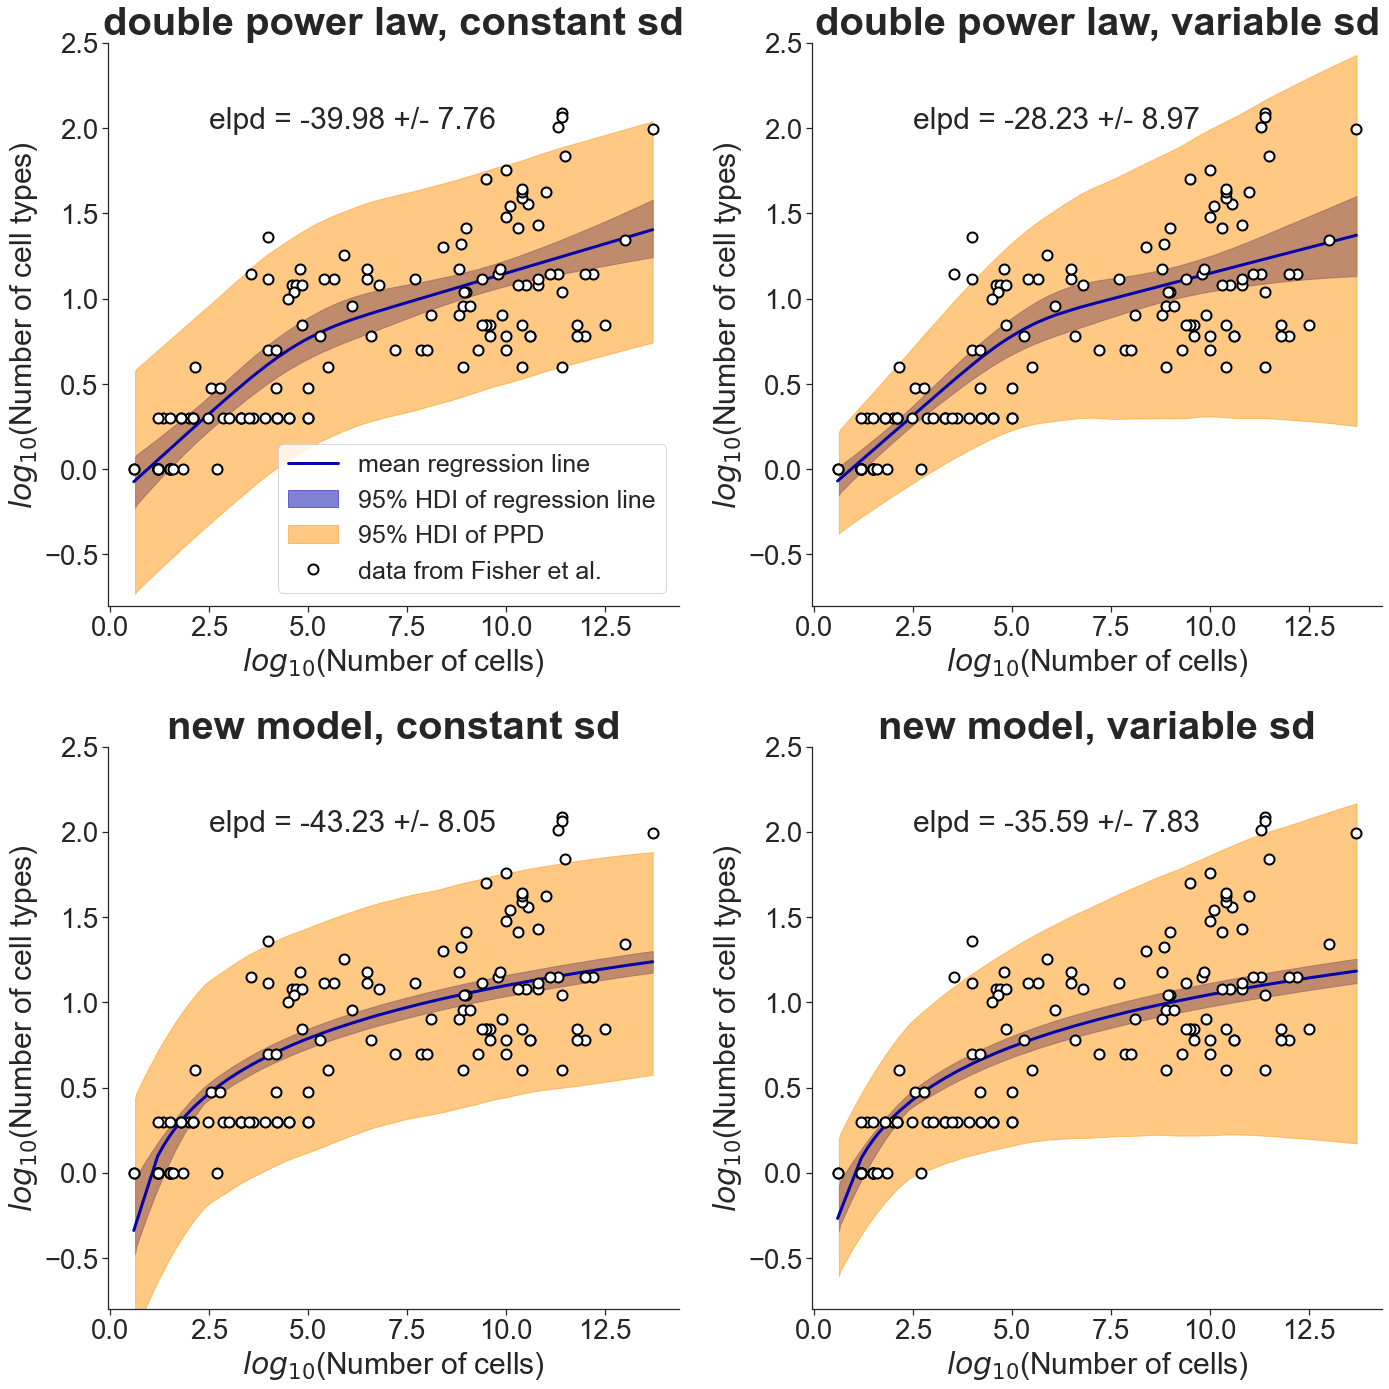

In [388]:
sns.set(font_scale=2.5,style="ticks")
fig,ax = plt.subplots(figsize=[20,20],ncols=2,nrows=2)

plot_model(dat,trace_plaw_simple,ax[0,0])
ax[0,0].legend(loc='lower right',fontsize=25)
ax[0,0].set_title('double power law, constant sd',fontsize=40,fontweight='bold')
elpd = str(round(model_compare.loc['power law, fixed spread','loo'],2))
elpd_se = str(round(model_compare.loc['power law, fixed spread','se'],2))
ax[0,0].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se,fontsize=30)

plot_model(dat,trace_plaw_complete,ax[0,1])
ax[0,1].set_title('double power law, variable sd',fontsize=40,fontweight='bold')
elpd = str(round(model_compare.loc['power law, variable spread','loo'],2))
elpd_se = str(round(model_compare.loc['power law, variable spread','se'],2))
ax[0,1].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se,fontsize=30)

plot_model(dat,trace_new_simple,ax[1,0])
ax[1,0].set_title('new model, constant sd',fontsize=40,fontweight='bold')
elpd = str(round(model_compare.loc['new model, fixed spread','loo'],2))
elpd_se = str(round(model_compare.loc['new model, fixed spread','se'],2))
ax[1,0].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se ,fontsize=30)

plot_model(dat,trace_new_complete,ax[1,1])
ax[1,1].set_title('new model, variable sd',fontsize=40,fontweight='bold')
elpd = str(round(model_compare.loc['new model, variable spread','loo'],2))
elpd_se = str(round(model_compare.loc['new model, variable spread','se'],2))
ax[1,1].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se,fontsize=30)

sns.despine()
plt.tight_layout()
plt.savefig('fig1.png')


### Save parameter estimates and result of model comparison (Table 1)

In [385]:

index = ['new model, variable spread','power law, variable spread',
           'new model, fixed spread','power law, fixed spread',
         'Fisher et al.'
           ]

columns = ['A','A HDI','B','B HDI','intercept_1','intercept_1 HDI','slope_1','slope_1 HDI',
           'breakpoint','breakpoint HDI', 'slope_2','slope_2 HDI',
        'sigma','sigma HDI', 'sigma_intercept','sigma_intercept HDI',
           'sigma_slope','sigma_slope HDI','elpd','elpd_se']

results = pd.DataFrame(columns = columns, index=index)

trace = trace_new_complete
modelname = 'new model, variable spread'
params = ['A','B','sigma_intercept','sigma_slope']

for param in params:
    results.loc[modelname,param] = get_post_mean(trace,param)
    results.loc[modelname,param + ' HDI'] = get_hdi(trace,param)

    
results.loc[modelname,'elpd'] = round(model_compare.loc[modelname,'loo'],2)
results.loc[modelname,'elpd_se'] = round(model_compare.loc[modelname,'se'],2)


trace = trace_new_simple
modelname = 'new model, fixed spread'
params = ['A','B','sigma']

for param in params:
    results.loc[modelname,param] = get_post_mean(trace,param)
    results.loc[modelname,param + ' HDI'] = get_hdi(trace,param)
    
results.loc[modelname,'elpd'] = round(model_compare.loc[modelname,'loo'],2)
results.loc[modelname,'elpd_se'] = round(model_compare.loc[modelname,'se'],2)

trace = trace_plaw_complete
modelname = 'power law, variable spread'
params = ['slope_1','slope_2','breakpoint','intercept_1','sigma_intercept','sigma_slope']

for param in params:
    results.loc[modelname,param] = get_post_mean(trace,param)
    results.loc[modelname,param + ' HDI'] = get_hdi(trace,param)
    
results.loc[modelname,'elpd'] = round(model_compare.loc[modelname,'loo'],2)
results.loc[modelname,'elpd_se'] = round(model_compare.loc[modelname,'se'],2)


trace = trace_plaw_simple
modelname = 'power law, fixed spread'
params = ['slope_1','slope_2','breakpoint','intercept_1','sigma']

for param in params:
    results.loc[modelname,param] = get_post_mean(trace,param)
    results.loc[modelname,param + ' HDI'] = get_hdi(trace,param)
    
results.loc[modelname,'elpd'] = round(model_compare.loc[modelname,'loo'],2)
results.loc[modelname,'elpd_se'] = round(model_compare.loc[modelname,'se'],2)


results.loc['Fisher et al.','slope_1'] = 0.21
results.loc['Fisher et al.','slope_2'] = 0.07
results.loc['Fisher et al.','breakpoint'] = np.round(np.log10(6.3e4),2)

results.T.to_csv('scale_manuscript_table1.csv')
results





,A,A HDI,B,B HDI,intercept_1,intercept_1 HDI,slope_1,slope_1 HDI,breakpoint,breakpoint HDI,slope_2,slope_2 HDI,sigma,sigma HDI,sigma_intercept,sigma_intercept HDI,sigma_slope,sigma_slope HDI,elpd,elpd_se
"new model, variable spread",-0.13,"[-0.42, 0.16]",1.13,"[0.93, 1.32]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17,"[0.1, 0.24]",0.02,"[0.01, 0.04]",-35.59,7.83
"power law, variable spread",NaN,NaN,NaN,NaN,-0.19,"[-0.3, -0.08]",0.2,"[0.16, 0.25]",5.18,"[3.52, 6.84]",0.06,"[0.01, 0.1]",NaN,NaN,0.12,"[0.06, 0.19]",0.03,"[0.02, 0.04]",-28.23,8.97
"new model, fixed spread",-0.29,"[-0.64, 0.08]",1.29,"[1.08, 1.48]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,"[0.29, 0.37]",NaN,NaN,NaN,NaN,-43.23,8.05
"power law, fixed spread",NaN,NaN,NaN,NaN,-0.2,"[-0.41, -0.01]",0.21,"[0.13, 0.29]",4.81,"[2.73, 6.7]",0.07,"[0.03, 0.1]",0.32,"[0.28, 0.36]",NaN,NaN,NaN,NaN,-39.98,7.76
Fisher et al.,NaN,NaN,NaN,NaN,NaN,NaN,0.21,NaN,4.8,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
